# **Introduction**

I was asked to build a model that can predict credit risk using a dataset provided by the company, which consists of data on loans accepted and rejected.

# **Libraries**

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 10

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, plot_precision_recall_curve

In [2]:
%pip install scorecardpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.8 MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=b4fb965ae1c4071f0bc513102450d3414ef429067008a5e33972a65742128d5b
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy


In [3]:
import scorecardpy as sc

# **Dataset**

In [4]:
!gdown --id 10b8IZ8KPOxonevuT_1yeD-ntUH5_O82B

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10b8IZ8KPOxonevuT_1yeD-ntUH5_O82B
To: /content/loan_data_2007_2014.csv
100% 240M/240M [00:02<00:00, 100MB/s] 


In [5]:
data = pd.read_csv('loan_data_2007_2014.csv')
data.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,1069639,1304742,7000,7000,7000.0,60 months,15.96,170.08,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,1072053,1288686,3000,3000,3000.0,36 months,18.64,109.43,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data = data.iloc[:,1:] # remove first column
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [8]:
print("Total Null values in the Data Frame:", data.isnull().values.sum()) # check number of null values in the Data Frame

Total Null values in the Data Frame: 9776224


In [9]:
nullseries = data.isnull().sum()
print(nullseries[nullseries > 0].sort_values())

annual_inc                          4
title                              20
acc_now_delinq                     29
delinq_2yrs                        29
earliest_cr_line                   29
inq_last_6mths                     29
open_acc                           29
pub_rec                            29
total_acc                          29
last_credit_pull_d                 42
collections_12_mths_ex_med        145
revol_util                        340
last_pymnt_d                      376
emp_length                      21008
emp_title                       27588
total_rev_hi_lim                70276
tot_coll_amt                    70276
tot_cur_bal                     70276
next_pymnt_d                   227214
mths_since_last_delinq         250351
desc                           340302
mths_since_last_major_derog    367311
mths_since_last_record         403647
inq_fi                         466285
all_util                       466285
max_bal_bc                     466285
open_rv_24m 

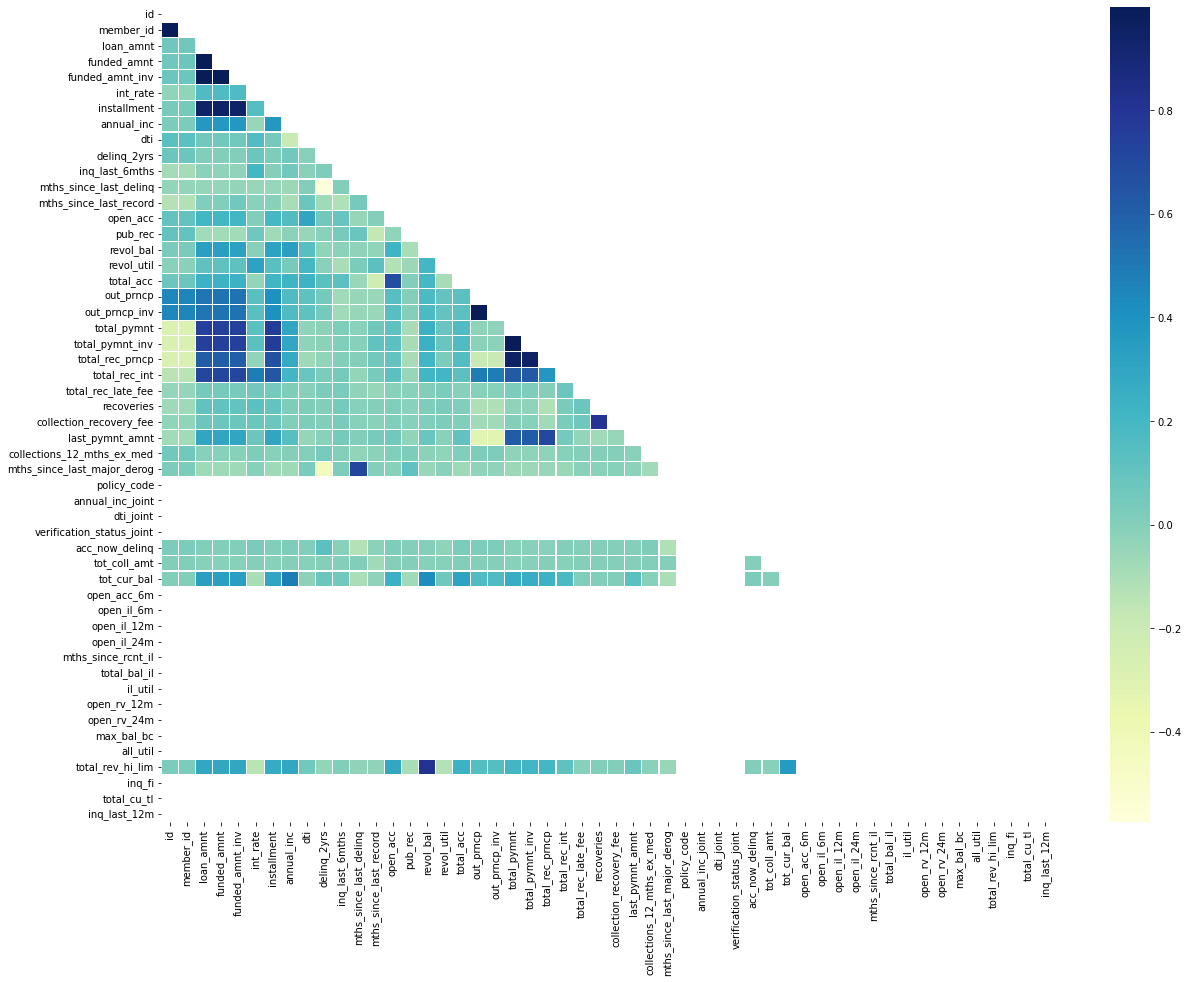

In [10]:
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(), cmap="YlGnBu", linewidths=.1, mask=mask, ax=ax)

# **Data Preparation**

In [11]:
# Select numeric columns
num = data.select_dtypes('number')
# Select string and object columns
obj = data.select_dtypes('object')

# Fill numeric columns with mean
data[num.columns] = num.fillna(num.mean())
# Fill object columns with mode
data[obj.columns] = obj.fillna(obj.agg(lambda x: x.mode().values[0]))

Target Feature: loan_status

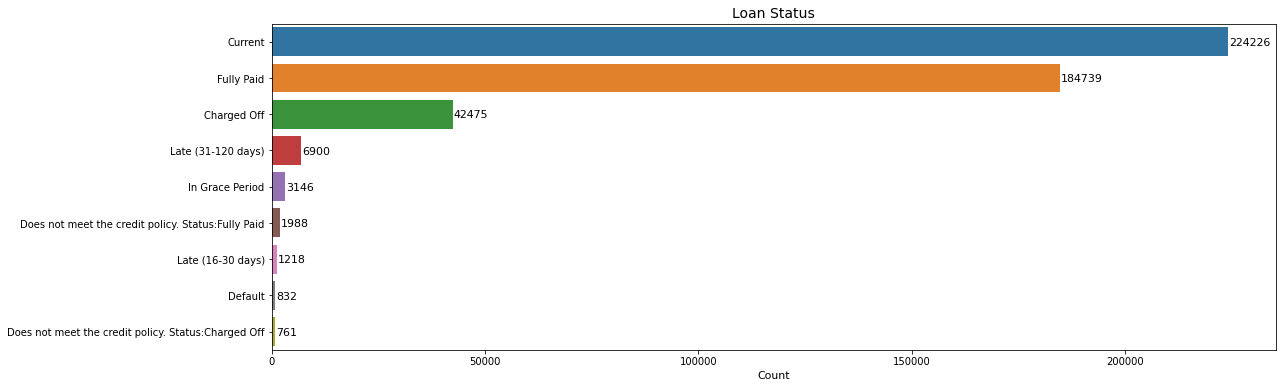

In [12]:
f, ax = plt.subplots(figsize=(18, 6))
cp = sns.countplot(y='loan_status', data=data, ax=ax, order=data['loan_status'].value_counts().index)
cp.set_xlabel('Count', fontsize=11)
cp.set_ylabel(None)
cp.set_title('Loan Status', fontsize=14)
for p in cp.patches:
    cp.annotate(int(p.get_width()), ((p.get_x() + p.get_width()), p.get_y()), xytext=(1, -18), fontsize=11, color='black', textcoords='offset points', horizontalalignment='left')

Categorize and replace the values of loan_status:
*   Good loan = 0
*   Bad loan = 1



In [13]:
data['loan_status'] = data['loan_status'].replace(['Current','Fully Paid','In Grace Period','Default'], 0)
data['loan_status'] = data['loan_status'].replace(['Charged Off','Late (31-120 days)','Does not meet the credit policy. Status:Fully Paid',
                                                   'Late (16-30 days)','Does not meet the credit policy. Status:Charged Off'], 1)

In [14]:
data['loan_status'].value_counts()

0    412943
1     53342
Name: loan_status, dtype: int64

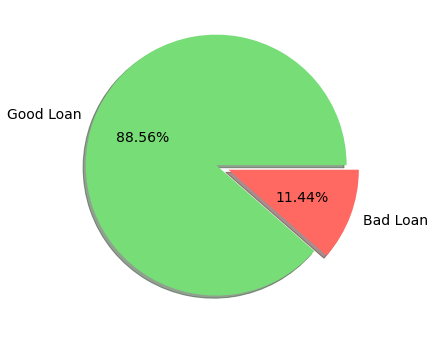

In [15]:
plt.figure(figsize=(6,6))
labels = ['Good Loan', 'Bad Loan']
colors = ['#77DD77', '#ff6961']
explode = [0.1, 0]

pie = plt.pie(x=data['loan_status'].value_counts(), labels=labels, colors=colors, explode=explode, shadow=True, autopct='%.2f%%', textprops={'fontsize': 14})

plt.show()

In [16]:
sample_data = data.sample(frac=.30)

In [17]:
if (len(data)!=len(sample_data)):
  print("Data has been reduced to 30% as the data sample.")
  print("Total rows of previous dataframe ->", len(data))
  print("Total rows of new dataframe      ->", len(sample_data))

Data has been reduced to 30% as the data sample.
Total rows of previous dataframe -> 466285
Total rows of new dataframe      -> 139886


# **Feature Selection**

Selecting feature using Weight of Evidence (WoE) and Information Value (IV)

In [18]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [19]:
final_iv, IV = data_vars(sample_data,sample_data.loan_status)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,id,57167.0,855189.0,9992,1968.0,0.196958,8024.0,0.803042,0.124478,0.064670,0.654832,0.141916
1,id,855245.0,1427559.0,9992,1575.0,0.157626,8417.0,0.842374,0.099620,0.067837,0.384253,0.141916
2,id,1427629.0,3065399.0,9992,1529.0,0.153022,8463.0,0.846978,0.096711,0.068208,0.349162,0.141916
3,id,3065413.0,4785520.0,9992,1399.0,0.140012,8593.0,0.859988,0.088488,0.069256,0.245061,0.141916
4,id,4785535.0,6531172.0,9991,1333.0,0.133420,8658.0,0.866580,0.084314,0.069780,0.189200,0.141916
...,...,...,...,...,...,...,...,...,...,...,...,...
275567,total_rev_hi_lim,0.0,27000.0,69961,7918.0,0.113177,62043.0,0.886823,0.500822,0.500040,0.001563,0.000002
275568,total_rev_hi_lim,27010.0,1998700.0,69925,7892.0,0.112864,62033.0,0.887136,0.499178,0.499960,-0.001565,0.000002
275569,inq_fi,NaN,NaN,139886,15810.0,0.113021,124076.0,0.886979,1.000000,1.000000,0.000000,0.000000
275570,total_cu_tl,NaN,NaN,139886,15810.0,0.113021,124076.0,0.886979,1.000000,1.000000,0.000000,0.000000


In [21]:
data_iv = IV[IV.IV>=0.3].sort_values('IV', ascending=False)
data_iv

,VAR_NAME,IV
30,last_pymnt_d,1.836294
67,total_rec_prncp,1.293668
29,last_pymnt_amnt,1.014053
46,out_prncp,0.748691
47,out_prncp_inv,0.748691
64,total_pymnt_inv,0.627082
63,total_pymnt,0.595148
28,last_credit_pull_d,0.386320
55,sub_grade,0.329593
26,int_rate,0.320110


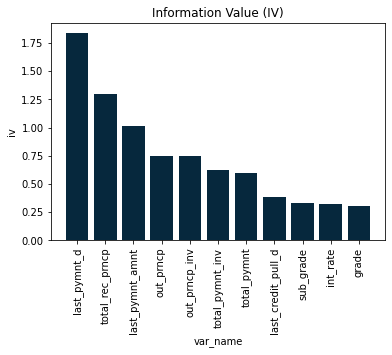

In [22]:
plt.bar('VAR_NAME', 'IV', data=data_iv, color='#06283D')
plt.title('Information Value (IV)')
plt.xlabel('var_name')
plt.ylabel('iv')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Selecting feature (based on WOE & IV results)
data_iv = data[['total_rec_prncp','out_prncp','out_prncp_inv','last_pymnt_amnt','total_pymnt_inv','total_pymnt','sub_grade','int_rate','grade','loan_status']]
data_iv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   total_rec_prncp  466285 non-null  float64
 1   out_prncp        466285 non-null  float64
 2   out_prncp_inv    466285 non-null  float64
 3   last_pymnt_amnt  466285 non-null  float64
 4   total_pymnt_inv  466285 non-null  float64
 5   total_pymnt      466285 non-null  float64
 6   sub_grade        466285 non-null  object 
 7   int_rate         466285 non-null  float64
 8   grade            466285 non-null  object 
 9   loan_status      466285 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 35.6+ MB


In [24]:
bins = sc.woebin(data_iv, y='loan_status')

[INFO] creating woe binning ...
Binning on 466285 rows and 10 columns in 00:00:25


{'grade': <Figure size 432x288 with 2 Axes>,
 'int_rate': <Figure size 432x288 with 2 Axes>,
 'last_pymnt_amnt': <Figure size 432x288 with 2 Axes>,
 'out_prncp': <Figure size 432x288 with 2 Axes>,
 'out_prncp_inv': <Figure size 432x288 with 2 Axes>,
 'sub_grade': <Figure size 432x288 with 2 Axes>,
 'total_pymnt': <Figure size 432x288 with 2 Axes>,
 'total_pymnt_inv': <Figure size 432x288 with 2 Axes>,
 'total_rec_prncp': <Figure size 432x288 with 2 Axes>}

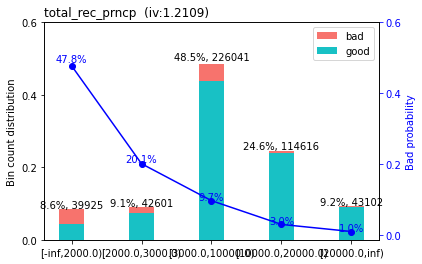

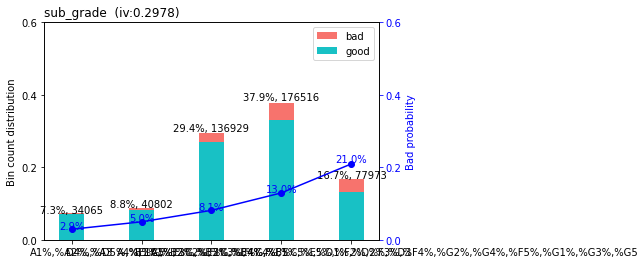

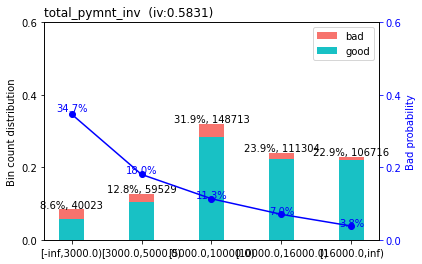

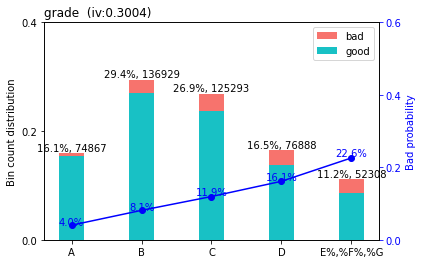

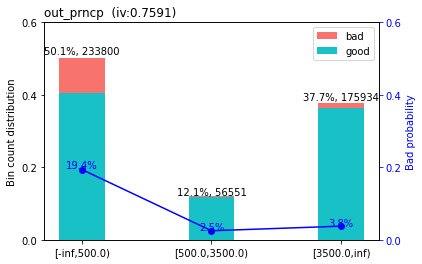

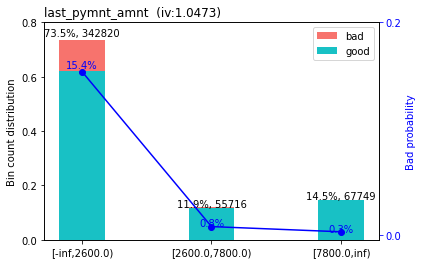

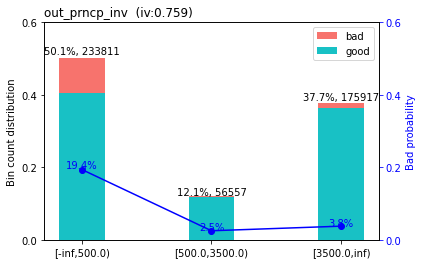

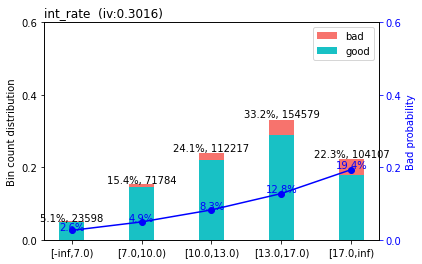

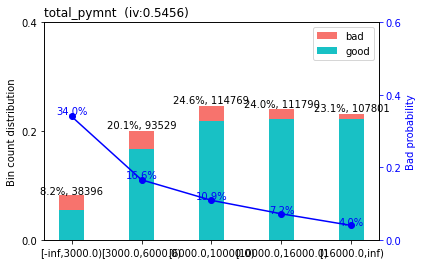

In [25]:
sc.woebin_plot(bins)

# **Modeling**

Using Logistic Regression as the prediction model

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_iv['sub_grade'] = le.fit_transform(data_iv['sub_grade'])
data_iv['grade'] = le.fit_transform(data_iv['grade'])

In [27]:
X = data_iv.drop(['loan_status'], axis=1)
y = data_iv['loan_status']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [29]:
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
print(model)

LogisticRegression()


In [30]:
# Predicting the model
pred_lr = lr.predict(X_test)

# **Evaluation**

In [31]:
print("The accuracy of this model is:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

The accuracy of this model is: 0.9418595923094245
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     82660
           1       0.94      0.52      0.67     10597

    accuracy                           0.94     93257
   macro avg       0.94      0.76      0.82     93257
weighted avg       0.94      0.94      0.93     93257



In [32]:
# Model evaluation metrics
print("Accuracy \t:", accuracy_score(y_test, pred_lr))
print("Precision\t:", precision_score(y_test, pred_lr))
print("Recall \t\t:", recall_score(y_test, pred_lr))

Accuracy 	: 0.9418595923094245
Precision	: 0.9428375834331679
Recall 		: 0.5198641124846655


In [33]:
# Use Confusion Matrix to evaluate the performance of a classification model
cm = confusion_matrix(y_test, pred_lr)
print(cm)

[[82326   334]
 [ 5088  5509]]


Text(0.5, 15.0, 'Predicted Label')

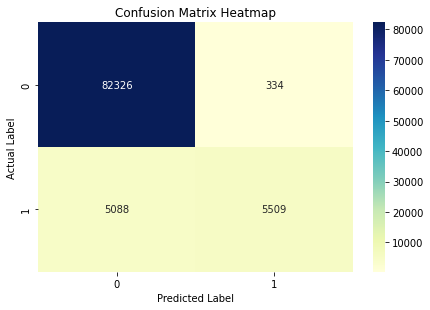

In [34]:
# Visualizing Confusion Matrix using Heatmap

class_names=['Bad','Good'] # Name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create Heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" , fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix Heatmap', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

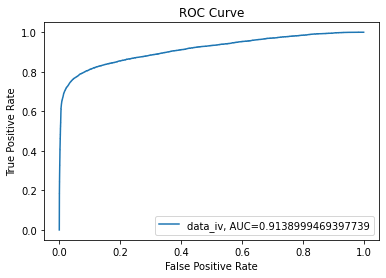

In [35]:
# Receiver Operating Characteristic (ROC) Curve 
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data_iv, AUC="+str(auc))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories.

**AUC score for the case is 0.91** 

AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier